# KITTI correspondences

## Prepare datasets

In [6]:
%reload_ext autoreload
%autoreload 2

import sys
import numpy as np
np.set_printoptions(precision=4, suppress=True)
KITTI_ROOT_PATH = '/home/ruizhu/Documents/Datasets/kitti'
KITTI_PATH = KITTI_ROOT_PATH + '/raw'

sys.path.append(KITTI_ROOT_PATH+'/kitti-lidar-utils')
sys.path.append(KITTI_ROOT_PATH+'/kitti-lidar-utils/source')
sys.path.append(KITTI_ROOT_PATH+'/depth/devkit/python')
# print(sys.path)
import itertools
import pdb
import pykitti  # install using pip install pykitti
import os
from PIL import Image, ImageOps
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.io import savemat
# from mayavi import mlab
# mlab.init_notebook() # http://docs.enthought.com/mayavi/mayavi/tips.html
# mlab.options.offscreen = True
# from imayavi import *
import time
from source.utils import load_tracklets_for_frames, point_inside, in_hull
from source import parseTrackletXML as xmlParser
from source.kitti_util import *
import argparse
from matplotlib import cm
from cluster_pcs.filters import *
from math import atan2, degrees
# from plyfile import PlyData, PlyElement
from PIL import Image
from read_depth import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Select sequence
date_name = '2011_09_26'
seq_name = '_drive_0005_sync'
tracklet_path = KITTI_PATH+'/%s/%s/tracklet_labels.xml'%(date_name, date_name+seq_name)
fdir_path = KITTI_PATH+'/%s/%s/'%(date_name, date_name+seq_name)
if os.path.exists(tracklet_path):
    print('======Tracklet Exists:', tracklet_path)
else:
    print('======Tracklet NOT Exists:', tracklet_path)
    
## Raw Data directory information
path = fdir_path.rstrip('/')
basedir = path.rsplit('/',2)[0]
date = path.split('/')[-2]
drive = path.split('/')[-1].split('_')[-2]

dataset = pykitti.raw(basedir, date, drive)
tracklet_rects, tracklet_types, tracklet_ids, tracklet_Rs, tracklet_ts = load_tracklets_for_frames(len(list(dataset.velo)),\
               '{}/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(basedir,date, date, drive))
# print(tracklet_Rs[0][0].shape, tracklet_ts[0][0].shape)
dataset_gray = list(dataset.gray)
dataset_rgb = list(dataset.rgb) 

======Tracklet Exists: /home/ruizhu/Documents/Datasets/kitti/raw/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
Parsing tracklet file /home/ruizhu/Documents/Datasets/kitti/raw/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
File contains 15 tracklets
Loaded 15 tracklets.


## Get camera in binocular setting

In [7]:
## From Rui
# Understanding calibs: https://github.com/utiasSTARS/pykitti/blob/0e5fd7fefa7cd10bbdfb5bd131bb58481d481116/pykitti/raw.py#L150
cam = 'leftRGB'
P_rects = {'leftRGB':dataset.calib.P_rect_20, 'rightRGB':dataset.calib.P_rect_30} # cameras def.: https://github.com/utiasSTARS/pykitti/blob/19d29b665ac4787a10306bbbbf8831181b38eb38/pykitti/odometry.py#L42
cam2cam = {}
R_cam2rect = dataset.calib.R_rect_00 # [cam0] R_rect_xx: 3x3 rectifying rotation to make image planes co-planar
P_rect = P_rects['leftRGB'] # P_rect_0[0-3]: 3x4 projection matrix after rectification; the reprojection matrix in MV3D
velo2cam = dataset.calib.T_cam0_velo_unrect
P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam) # 4*3

# Compute cam2 to cam 3 (pure translation)
print(dataset.calib.P_rect_20)
# print(dataset.calib.P_rect_30)
A = dataset.calib.P_rect_20[:, 0:3]
b = dataset.calib.P_rect_20[:, 3:4] - dataset.calib.P_rect_30[:, 3:4]
t = np.linalg.solve(A, b)
T = np.eye(4)
T[0:3, 3:4] = t
print(T)
print(np.matmul(dataset.calib.P_rect_30, T)) # should equal dataset.calib.P_rect_20
t_gt = t.copy()
print(t_gt)

[[721.5377   0.     609.5593  44.8573]
 [  0.     721.5377 172.854    0.2164]
 [  0.       0.       1.       0.0027]]
[[ 1.      0.      0.      0.5327]
 [ 0.      1.      0.     -0.0028]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]
[[721.5377   0.     609.5593  44.8573]
 [  0.     721.5377 172.854    0.2164]
 [  0.       0.       1.       0.0027]]
[[ 0.5327]
 [-0.0028]
 [ 0.    ]]


# Sample of binocular images and projections

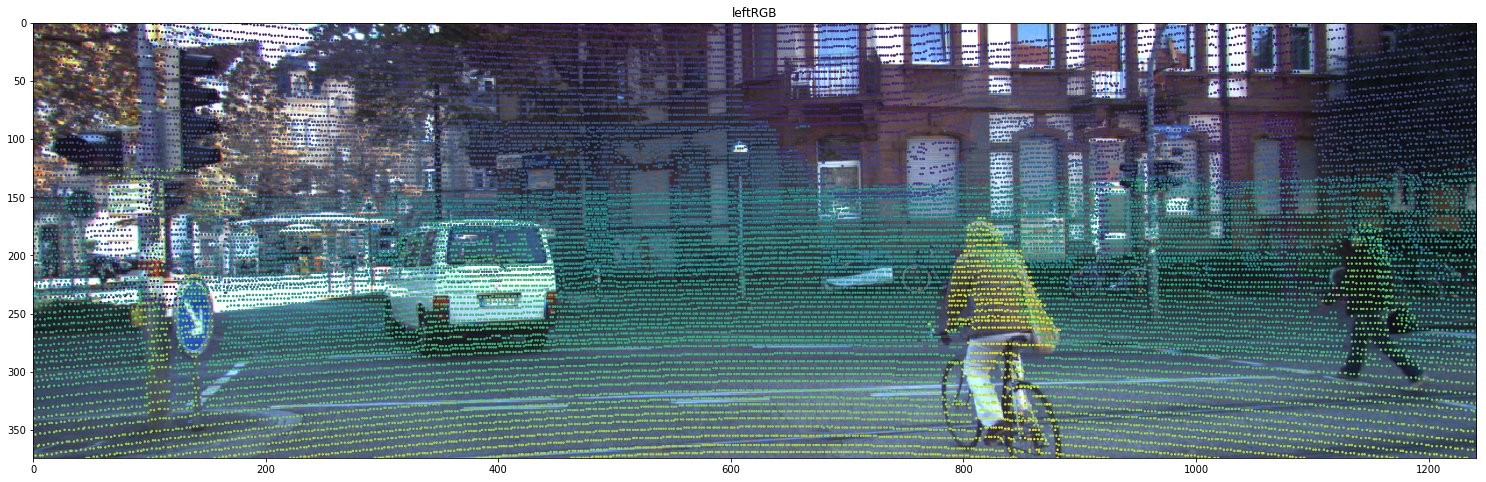

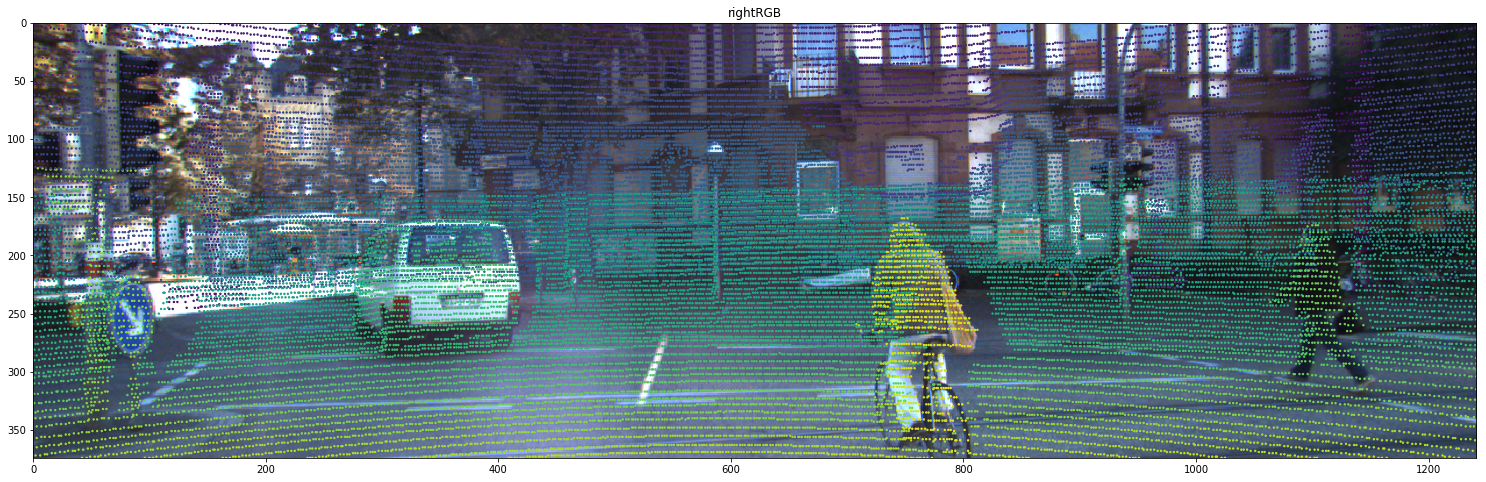

In [8]:
def xyz_to_hom(xyzs):
    # xysz: 3*N
    return np.vstack((xyzs, np.ones((1, xyzs.shape[1]))))

fig_scale = 300
fig_ratio = [4, 3]

velo_pts_im_list = []

for i,velo in enumerate(dataset.velo):
    ## Plot 3: Projection
#     vel_depth = True
    im_shape = [375, 1242]
    # project the points to the camera
    # Filter points inside bbox
    velo_reproj = velo[:, :3]
    velo_reproj = np.hstack((velo_reproj, np.ones((velo_reproj.shape[0], 1))))
    
    for cam_iter, cam in enumerate(['leftRGB', 'rightRGB']):
        P_rect = P_rects[cam] # P_rect_0[0-3]: 3x4 projection matrix after rectification; the reprojection matrix in MV3D
        P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam) # 4*3
        
        velo_pts_im = np.dot(P_velo2im, velo_reproj.T).T # [*, 3]
        velo_pts_im[:, :2] = velo_pts_im[:,:2] / velo_pts_im[:,2][..., np.newaxis]
    #     if vel_depth: # Use velo first dimmension as depth
    #         velo_pts_im[:, 2] = velo_reproj[:, 0]
        
        velo_pts_im_list.append(velo_pts_im.copy())
        
        # check if in bounds
        # use minus 1 to get the exact same value as KITTI matlab code
        velo_pts_im[:, 0] = np.round(velo_pts_im[:,0]) - 1
        velo_pts_im[:, 1] = np.round(velo_pts_im[:,1]) - 1
        val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
        val_inds = val_inds & (velo_pts_im[:,0] < im_shape[1]) & (velo_pts_im[:,1] < im_shape[0])
        velo_pts_im = velo_pts_im[val_inds, :]

        plt.figure(figsize=(30, 8))
        plt.imshow(dataset_rgb[i][cam_iter])
        plt.scatter(velo_pts_im[:, 0].astype(np.int), velo_pts_im[:, 1].astype(np.int), s=2, c=1./velo_pts_im[:, 2])
        plt.xlim(0, im_shape[1]-1)
        plt.ylim(im_shape[0]-1, 0)
        plt.title(cam)
        plt.show()

    #     if i > 1:
    break

## Get rectified delta R, delta t, and X

[[721.5377   0.     609.5593  44.8573]
 [  0.     721.5377 172.854    0.2164]
 [  0.       0.       1.       0.0027]]
[[ 721.5377    0.      609.5593 -339.5242]
 [   0.      721.5377  172.854     2.1999]
 [   0.        0.        1.        0.0027]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.0598]
 [-0.0004]
 [ 0.0027]]
[[-0.4729]
 [ 0.0024]
 [ 0.0027]]
(3, 123397)
(3, 60242)


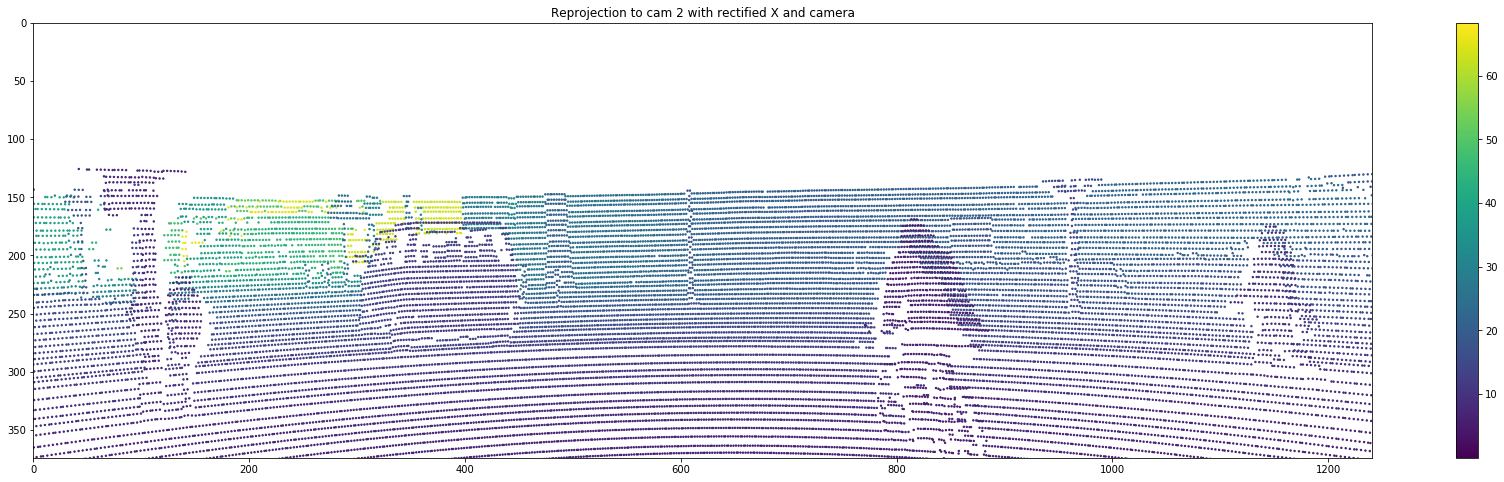

(60242,)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[-0.5327]
 [ 0.0028]
 [-0.    ]]


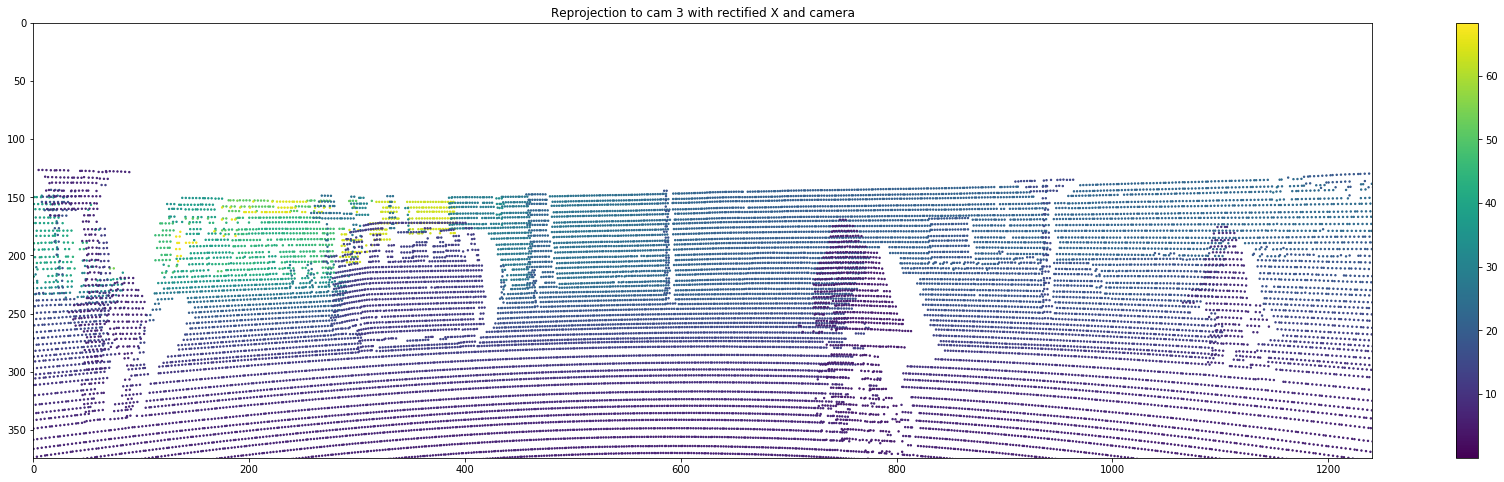

(60242,)
(60242,)


In [9]:
import torch

# https://github.com/vcg-uvic/learned-correspondence-release/blob/16bef8a0293c042c0bd42f067d7597b8e84ef51a/network.py#L160
def torch_skew_symmetric(v): # v: [3, 1]
    zero = torch.zeros_like(v[0, 0])
    M = torch.stack([
        zero, -v[2, 0], v[1, 0],
        v[2, 0], zero, -v[0, 0],
        -v[1, 0], v[0, 0], zero,
    ], dim=0)
    return torch.reshape(M, (3, 3))

def scatter_xy(xy, c, im_shape, title=''):
    plt.figure(figsize=(30, 8))
    plt.scatter(xy[:, 0], xy[:, 1], s=2, c=c)
    plt.colorbar()
    plt.xlim(0, im_shape[1]-1)
    plt.ylim(im_shape[0]-1, 0)
    plt.title(title)
    plt.show()
    val_inds = (xy[:, 0] >= 0) & (xy[:, 1] >= 0)
    val_inds = val_inds & (xy[:,0] < im_shape[1]) & (xy[:,1] < im_shape[0])
    return val_inds

def homo_py(x):
    # input: x [N, 2]
    # output: x_homo [N, 3]
    N = list(x.size())[0]
    x_homo = torch.cat((x, torch.ones(N, 1)), 1)
    return x_homo

def de_homo_py(x_homo):
    # input: x_homo [N, 3]
    # output: x [N, 2]
    N = list(x_homo.size())[0]
    epi = 1e-10
    x = torch.cat((x_homo[:, 0:1]/(x_homo[:, 2:3]+epi), x_homo[:, 1:2]/(x_homo[:, 2:3]+epi)), 1)
    return x

# for idx in range(2):
#     val_inds = scatter_xy(velo_pts_im_list[idx], velo_pts_im_list[idx][:, 2], im_shape, 'Reprojection to cam %d with KITTI camera matrix'%(2+idx))
    
print(dataset.calib.P_rect_20)
print(dataset.calib.P_rect_30)
K = dataset.calib.P_rect_20[:3, :3]
M1_gt = np.matmul(np.linalg.inv(K), dataset.calib.P_rect_20)
M2_gt = np.matmul(np.linalg.inv(K), dataset.calib.P_rect_30)

t1_gt = M1_gt[:, 3:4]
t2_gt = M2_gt[:, 3:4]
R1_gt = M1_gt[:, :3]
R2_gt = M2_gt[:, :3]
print(R1_gt)
print(R2_gt)
print(t1_gt)
print(t2_gt)

val_inds_list = []

X_homo = np.dot(np.dot(R_cam2rect, velo2cam), velo_reproj.T) # 4*N
R1t1_gt = np.vstack((np.hstack((R1_gt, t1_gt)), np.array([0., 0., 0., 1.], dtype=np.float64)))
X_homo_rect = np.matmul(R1t1_gt, X_homo)
X_rect = X_homo_rect[:3, :] / X_homo_rect[3:4, :]

# X_rect = -X_rect
front_mask = X_rect[-1, :]>0
print(X_rect.shape)
X_rect = X_rect[:, front_mask]
print(X_rect.shape)
X_homo_rect = X_homo_rect[:, front_mask]
velo_pts_im_list[0] = velo_pts_im_list[0][front_mask, :]
velo_pts_im_list[1] = velo_pts_im_list[1][front_mask, :]

# Plot with recfitied X and R, t
x1_homo = np.matmul(K, np.matmul(np.hstack((np.eye(3), np.zeros((3, 1)))), X_homo_rect)).T
x1 = x1_homo[:, 0:2]/x1_homo[:, 2:3]
val_inds = scatter_xy(x1, x1_homo[:, 2], im_shape, 'Reprojection to cam 2 with rectified X and camera')
print(val_inds.shape)
val_inds_list.append(val_inds)

delta_Rt_gt = np.matmul(np.hstack((R2_gt, t2_gt)), np.linalg.inv(R1t1_gt))
delta_R_gt = delta_Rt_gt[:, :3]
delta_t_gt = delta_Rt_gt[:, 3:4]
print(delta_R_gt, delta_t_gt)
x2_homo = np.matmul(K, np.matmul(np.hstack((delta_R_gt, delta_t_gt)), X_homo_rect)).T
x2 = x2_homo[:, :2]/x2_homo[:, 2:3]
val_inds = scatter_xy(x2, x2_homo[:, 2], im_shape, 'Reprojection to cam 3 with rectified X and camera')
print(val_inds.shape)
val_inds_list.append(val_inds)

val_inds_both = val_inds_list[0] & val_inds_list[1]
print(val_inds_both.shape)
val_idxes = [idx for idx in range(val_inds_both.shape[0]) if val_inds_both[idx]] # within indexes

# plt.figure(figsize=(30, 8))
# plt.scatter(x1[val_idxes, 0:1], x1[val_idxes, 1:2], s=2)
# plt.show()

# Visualization with >> inspect_kitti_rectified.m
savemat('X_rectified.mat', {'X_homo_rect':X_homo_rect, 'velo_homo': velo_reproj[front_mask, :].T, 'K':K, 'val_idxes':val_idxes})

## Epipolar constriants, and solving for E and F

In [15]:
np.set_printoptions(precision=8, suppress=True)

t_x = torch_skew_symmetric(torch.from_numpy(delta_t_gt).float())
E_gt_th = torch.matmul(t_x, torch.eye(3))
K_th = torch.from_numpy(K).float()

import random
random.seed(10)
random_idx= random.sample(val_idxes, 1000)

# Verify the epipolar constraint
xy1 = torch.from_numpy(velo_pts_im_list[0][:, 0:2])
xy2 = torch.from_numpy(velo_pts_im_list[1][:, 0:2])
xy1_random = xy1[random_idx, :]
xy2_random = xy2[random_idx, :]
xy1_homo = homo_py(xy1_random.float())
xy2_homo = homo_py(xy2_random.float())
# should_zeros = torch.matmul(torch.matmul(xy2_homo, E), xy1_homo.t()).numpy()
F = torch.matmul(torch.matmul(torch.inverse(K_th).t(), E_gt), torch.inverse(K_th))
should_zeros = torch.matmul(torch.matmul(xy2_homo, F), xy1_homo.t()).numpy()
# print(np.diag(should_zeros))

# Recover E
## Create the matrix to be used for the eight-point algorithm
print(xy1_random.size())
xx = torch.cat([xy1_random.t(), xy2_random.t()], dim=0)
print(xx.size())
X = torch.stack([
    xx[2, :] * xx[0, :], xx[2, :] * xx[1, :], xx[2, :],
    xx[3, :] * xx[0, :], xx[3, :] * xx[1, :], xx[3, :],
    xx[0, :], xx[1, :], torch.ones_like(xx[0, :])
], dim=0).t()
XwX = torch.matmul(X.t(), X)
print("XwX shape = {}".format(XwX.shape))

# Recover essential matrix from self-adjoing eigen
e, v = torch.eig(XwX, eigenvectors=True)
print(t)
print('----E_gt', E_gt_th.numpy())
E_recover = v[:, 8].reshape((3, 3))
E_recover_rescale = E_recover / torch.norm(E_recover) * torch.norm(E_gt_th)
print('-E_recover', E_recover_rescale.numpy())
U, D, V = torch.svd(E_recover)
diag_sing = torch.diag(torch.tensor([1., 1., 0.], dtype=torch.float64))
E_recover_hat = torch.mm(U, torch.mm(diag_sing, V.t()))
E_recover_hat_rescale = E_recover_hat / torch.norm(E_recover_hat) * torch.norm(E_gt_th)
print('--E_recover_hat', E_recover_hat_rescale.numpy())

# Alternatively, Recover F
print('----', F.numpy())
U, D, V = torch.svd(X)
F_recover = torch.reshape(V[:, -1], (3, 3))
F_recover_rescale = F_recover / torch.norm(F_recover) * torch.norm(F)
print('-', F_recover_rescale.numpy())
FU, FD, FV= torch.svd(F_recover);
FDnew = torch.diag(FD);
FDnew[2, 2] = 0;
F_recover_sing = torch.mm(FU, torch.mm(FDnew, FV.t()))
F_recover_sing_rescale = F_recover_sing / torch.norm(F_recover_sing) * torch.norm(F)
print('-', F_recover_sing_rescale.numpy())

torch.Size([1000, 2])
torch.Size([4, 1000])
XwX shape = torch.Size([9, 9])
[[ 0.53271193]
 [-0.0027529 ]
 [ 0.00001598]]
----E_gt [[ 0.          0.00001598  0.0027529 ]
 [-0.00001598  0.          0.5327119 ]
 [-0.0027529  -0.5327119   0.        ]]
-E_recover [[ 0.         -0.00000002 -0.002749  ]
 [ 0.00000002 -0.         -0.53271196]
 [ 0.002749    0.53271196 -0.        ]]
--E_recover_hat [[-0.         -0.00000002 -0.002749  ]
 [ 0.00000002 -0.         -0.53271196]
 [ 0.002749    0.53271196 -0.        ]]
---- [[ 0.          0.          0.00000381]
 [-0.          0.          0.00073832]
 [-0.00000381 -0.00073832  0.        ]]
- [[-0.         -0.         -0.00000381]
 [ 0.         -0.         -0.00073832]
 [ 0.00000381  0.00073832  0.        ]]
- [[-0.         -0.         -0.00000381]
 [ 0.          0.         -0.00073832]
 [ 0.00000381  0.00073832  0.        ]]


## Four possible [R|t]

In [16]:
U, S, V = torch.svd(E_recover_hat)
W = torch.tensor([[0,-1,0], [1,0,0], [0,0,1]], dtype=torch.float64)
if torch.det(torch.mm(U, torch.mm(W, V.t())))<0:
    W = -W
print('-- delta_t_gt', delta_t_gt)

t_recover_rescale = U[:, 2]/torch.norm(U[:, 2])*np.linalg.norm(t_gt) # -t_recover_rescale is also an option
R_recover_1 = torch.mm(U, torch.mm(W, V.t()))
R_recover_2 = torch.mm(U, torch.mm(W.t(), V.t())) # also an option
print('-- t_recover_rescale', t_recover_rescale.numpy())
print('-- R_recover_1', R_recover_1.numpy(), torch.det(R_recover_1).numpy())
print('-- R_recover_2', R_recover_2.numpy(), torch.det(R_recover_2).numpy())

-- delta_t_gt [[-0.53271193]
 [ 0.0027529 ]
 [-0.00001598]]
-- t_recover_rescale [ 0.53271195 -0.002749    0.00000002]
-- R_recover_1 [[ 1. -0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]] 1.0000000000000004
-- R_recover_2 [[ 0.99994674 -0.0103205   0.00000008]
 [-0.0103205  -0.99994674 -0.        ]
 [ 0.00000008 -0.         -1.        ]] 1.0000000000000002


### Essential matrix decomposition with `cv2.recoverPose`: https://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#recoverpose
Check for Cheirality Condition using Triangulation: https://cmsc426.github.io/sfm/#tri

In [111]:
%reload_ext autoreload
%autoreload 2
import cv2 # pip install opencv-python==3.4.0.12
## Referring to https://github.com/vcg-uvic/learned-correspondence-release/blob/82adffad3f6fa3ea52aba9919cef00955c6d1617/tests.py#L185
num_inlier, R_cv2, t_cv2, mask_new = cv2.recoverPose(E_recover_hat.numpy(), xy2_random.numpy(), xy1_random.numpy()) # https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gadb7d2dfcc184c1d2f496d8639f4371c0
t_cv2_rescale = t_cv2/np.linalg.norm(t_cv2)*np.linalg.norm(t_gt) # -t_recover_rescale is also an option
print(R_cv2, t_cv2_rescale)

[[ 1. -0. -0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]] [[ 0.53271195]
 [-0.002749  ]
 [ 0.00000002]]


### Select one hypo from the 4 camera hypos for cam 3
only in one hypo the depths in both cameras are positive (e.g. frontal-facing),
which is `hypo 2`

In [115]:
R1 = np.eye(3)
t1 = np.zeros((3, 1))
R2s = [R_recover_1.numpy(), R_recover_2.numpy()]
t2s = [t_recover_rescale.numpy().reshape((3, 1)), -t_recover_rescale.numpy().reshape((3, 1))]
M1 = np.hstack((R1, t1))
M2s = [np.hstack((x, y)) for x, y in [(x,y) for x in R2s for y in t2s]]
Rt2s = [(x, y) for x, y in [(x,y) for x in R2s for y in t2s]]

np.set_printoptions(precision=4, suppress=True)

# https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#triangulatepoints
for cam_idx, M2 in enumerate(M2s):
    print('--- cam3 hypo %d/4'%(cam_idx+1))
    X_tri_homo = cv2.triangulatePoints(np.matmul(K, M1), np.matmul(K, M2), xy1[val_idxes, :].numpy().T, xy2[val_idxes, :].numpy().T)
    print('- cam 3', M2)
    X_tri = X_tri_homo[:3, :]/X_tri_homo[-1, :]
    print('- depth in cam 2', X_tri[-1, ])
    cheirality1 = np.matmul(R1[2:3, :], (X_tri-t1))
    print('- Cheirality Condition r3(X−C)>0', cheirality1)
    
#     # plot reprojected points
#     x1_tri_homo = np.matmul(K, np.matmul(np.hstack((np.eye(3), np.zeros((3, 1)))), X_tri_homo)).T
#     x1_tri = x1_tri_homo[:, :2]/x1_tri_homo[:, 2:3]
#     _ = scatter_xy(x1_tri, X_tri.T[:, 2], im_shape, 'Reprojection to cam 2 with TRIANGULATED X and camera %d'%cam_idx)

#     x2_tri_homo = np.matmul(K, np.matmul(np.hstack((Rt2s[cam_idx][0], Rt2s[cam_idx][1])), X_tri_homo)).T
#     x2_tri = x2_tri_homo[:, :2]/x2_tri_homo[:, 2:3]
#     _ = scatter_xy(x2_tri, X_tri.T[:, 2], im_shape, 'Reprojection to cam 2 with TRIANGULATED X and camera %d'%cam_idx)
    
    # compute how the point cloud looks from cam 3
    X_tri_cam3 = np.matmul(Rt2s[cam_idx][0], X_tri) + Rt2s[cam_idx][1]
    print('- depth in cam 3', X_tri_cam3[-1, :])
    cheirality2 = np.matmul(Rt2s[cam_idx][0][2:3, :], (X_tri-Rt2s[cam_idx][1]))
    print('- Cheirality Condition r3(X−C)>0', cheirality2)
    if np.min(cheirality1)>0 and np.min(cheirality2)>0:
        print('!!! Cheirality Condition meets for both cameras!')
    print('np.min(cheirality1), np.min(cheirality2):', np.min(cheirality1), np.min(cheirality2))

    savemat('cheirality_M2-%d.mat'%cam_idx, {'cheirality1':cheirality1, 'cheirality2':cheirality2, \
                                             'X_tri':X_tri, 'X_rect':X_rect[:, val_idxes], 'val_idxes':val_idxes, 'velo_reproj':velo_reproj, 'velo':velo[:, :3], 'aa':aa[:, :3]})
    
    

--- cam3 hypo 1/4
- cam 3 [[ 1.     -0.     -0.      0.5327]
 [ 0.      1.     -0.     -0.0027]
 [ 0.      0.      1.      0.    ]]
- depth in cam 2 [-22.4586 -17.7902 -17.7642 ...  -6.3351  -6.3371  -6.3391]
- Cheirality Condition r3(X−C)>0 [[-22.4586 -17.7902 -17.7642 ...  -6.3351  -6.3371  -6.3391]]
- depth in cam 3 [-22.4586 -17.7902 -17.7642 ...  -6.3351  -6.3371  -6.3391]
- Cheirality Condition r3(X−C)>0 [[-22.4586 -17.7902 -17.7642 ...  -6.3351  -6.3371  -6.3391]]
np.min(cheirality1), np.min(cheirality2): -68.26046233697717 -68.26046235928894
--- cam3 hypo 2/4
- cam 3 [[ 1.     -0.     -0.     -0.5327]
 [ 0.      1.     -0.      0.0027]
 [ 0.      0.      1.     -0.    ]]
- depth in cam 2 [22.4586 17.7902 17.7642 ...  6.3351  6.3371  6.3391]
- Cheirality Condition r3(X−C)>0 [[22.4586 17.7902 17.7642 ...  6.3351  6.3371  6.3391]]
- depth in cam 3 [22.4586 17.7902 17.7642 ...  6.3351  6.3371  6.3391]
- Cheirality Condition r3(X−C)>0 [[22.4586 17.7902 17.7642 ...  6.3351  6.3371  6